In [1]:
#get_ipython().system('jupyter nbconvert --to script 5a-Tutorial_Nui_Par_Fitting_Crab.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from gammapy.maps import Map
from gammapy.modeling import Parameter, Parameters
from gammapy.datasets import MapDataset 
from gammapy.modeling.models import FoVBackgroundModel, Models
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion, RectangleSkyRegion

from gammapy.modeling.models import   Models
import yaml
import sys

sys.path.append(
    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
)
from my_dataset_maps_19 import MapDatasetNuisance
from  my_fit_19 import Fit

In [2]:

def compute_K_matrix(l_deg, sigma, ndim_spatial_nui, ndim_spectral_nui,geom_down ):
    helper_map = Map.from_geom(geom_down).slice_by_idx(dict(energy=slice(0, 1)))
    helper_map2 = helper_map.copy()
    ndim_spatial_nui_1D = int(np.sqrt(ndim_spatial_nui))
    corr_matrix_spatial = np.identity(ndim_spatial_nui)
    for b_0 in range(ndim_spatial_nui_1D):
        for l_0 in range(ndim_spatial_nui_1D):
            i = b_0 * ndim_spatial_nui_1D + l_0
            C = SkyCoord(
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[0],
                helper_map.geom.pix_to_coord((l_0, b_0, 0))[1],
                frame=geom_down.frame,
            )
            helper_map.data[0, :, :] = C.separation(
                geom_down.to_image().get_coord().skycoord
            ).value
            helper_map2.data = np.zeros(ndim_spatial_nui_1D ** 2).reshape(
                helper_map2.geom.data_shape
            )
            helper_map2.data[0, :, :] = np.exp(
                -0.5 * helper_map.data[0, :, :] ** 2 / l_deg ** 2
            )
            corr_matrix_spatial[i, :] = helper_map2.data.flatten()

    corr_matrix_spectral = np.identity(ndim_spectral_nui)
    for e in range((ndim_spectral_nui)):
        corr_matrix_spectral[e, e] = sigma[e] ** 2
    return np.kron(corr_matrix_spectral, corr_matrix_spatial)

In [3]:
path = '/home/vault/caph/mppi062h/repositories/HESS_3Dbkg_syserror/2-error_in_dataset'

added = "_008_624"
source = 'Crab'
pathsource = f"{path}/{source}/"
dataset_N_import_624 = MapDatasetNuisance.read(f"{pathsource}nui_dataset{added}.fits")
with open(f'{pathsource}nui_par{added}.yml', "r") as ymlfile:
    nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
dataset_N_import_624.N_parameters = Parameters.from_dict(nui_par )
bkg_model = FoVBackgroundModel(dataset_name=dataset_N_import_624.name)

models = Models([])
models.append(bkg_model)
dataset_N_import_624.models =models
dataset_N_import_624.geoms['geom']
print(bkg_model.parameters['norm'].value)

emask = dataset_N_import_624.nuisance_mask.data.sum(axis=2).sum(axis=1) >0
xaxis = dataset_N_import_624.geoms['geom'].axes[0].center


1.0


In [4]:
with open('0_estimate_sys_per_ebin.yml', "r") as ymlfile:
    sys_read = yaml.load(ymlfile, Loader=yaml.FullLoader)
mus = sys_read['mus']
stds = sys_read['stds']

## Creating Mock Dataset

In [5]:
i_start = 6
i_end = 20

## change here if decided on cutout etc ...
#dataset_basic = dataset_N_import_624.cutout(dataset_N_import_624.geoms['geom'].center_skydir, 
#                                                  3.2*u.deg)
dataset_basic = dataset_N_import_624.copy()

downsampling_factor = 10
nuisance_mask = (
    dataset_basic.geoms["geom"]
    .energy_mask(
        energy_min=dataset_N_import_624.geoms["geom"].axes[0].edges[i_start],
        energy_max=dataset_N_import_624.geoms["geom"].axes[0].edges[i_end],
    )
    .downsample(downsampling_factor)
)
dataset_basic.nuisance_mask = nuisance_mask
bkg_model = FoVBackgroundModel(dataset_name=dataset_basic.name)
bkg_model.parameters["tilt"].frozen = False
models_N = Models([])
models_N.append(bkg_model)
dataset_basic.models = models_N

ndim_spatial_nui = dataset_basic.geoms['geom_down'].data_shape[1] **2
print("# of Nuis per ebin:", ndim_spatial_nui)
Nuisance_parameters = Parameters([Parameter(name = "db"+str(i), value = 0,frozen = False)  
            for i in range(ndim_spatial_nui * ( i_end -6) )])

l_corr, ndim_spectral_nui = 0.08,  i_end -i_start 
bg = dataset_basic.background
bg_e = bg.data.sum(axis=2).sum(axis=1)


# of Nuis per ebin: 225


In [6]:
amount_free_par = ndim_spatial_nui

def compute_nuisance_parameters (mus, stds, seed):
    nui_values_co = []
    if seed:
        np.random.seed(10)
    for i,e in enumerate(xaxis[i_start:i_end]):
        i =i +i_start
        mu, sigma_ = mus[i], stds[i]  # mean and standard deviation
        s = np.random.normal(mu, sigma_, int(amount_free_par))
        nui_values_co.append(s/100)
    nui_values_co = np.array(nui_values_co).flatten()
    return nui_values_co

def plot_nui_distribution(nui_values_co, sys, mus, stds):
    ii = i_end - i_start
    ii = ii // 3 + ii % 3
    fig, axs = plt.subplots(ii,3, figsize =(10,ii* 3) )
    for i,e in enumerate(xaxis[i_start:i_end]):
        ax = axs.flatten()[i]
        mu, sigma_ = mus[i+i_start], stds[i+i_start]  # mean and standard deviation
        s = nui_values_co[i*amount_free_par : (i+1)* amount_free_par]
        count, bins, ignored = ax.hist(s, 20, density=False, alpha = 0.3, color = 'red',)
        #ax.set_xlim(-10,10)
        ax.set_title(f'Energy: {xaxis[i+i_start].value:.2} TeV')
        ax.plot(bins,   max(count) *
                                np.exp( - (bins - mu)**2 / (2 * sigma_**2) ),
                          linewidth=2, color='r')
        ylim = ax.get_ylim()
        
        ax.vlines(0 +sys[i+i_start] *100, ylim[0], ylim[1],color = 'red' )
        ax.vlines(0 -sys[i+i_start] *100 , ylim[0], ylim[1],color = 'red')
    plt.tight_layout()
        
def plot_corr_matrix(dataset):
    M = np.linalg.inv(dataset.inv_corr_matrix)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(M)  # interpolation='nearest')
    fig.colorbar(cax);
    print("Maximal expected sys amplitude in % of bg:", np.sqrt( M.max() ) * 100)

def plot_residual(dataset, max_ = None):
    res_standard = (
        dataset.residuals("diff/sqrt(model)")
        #.slice_by_idx(dict(energy=slice(6, 9)))
        .smooth(0.1 * u.deg)
        )
    if max_ is None:
        vmax = np.nanmax(np.abs(res_standard.data))
    else:
        vmax = max_
    res_standard.slice_by_idx(dict(energy=slice(i_start,i_end))).plot_grid(add_cbar=1, 
                                                                  vmax=vmax, vmin=-vmax, cmap="coolwarm")
    return res_standard            


def create_dataset (mus, stds, falseningfactor,seed):
    
    emask = dataset_N_import_624.nuisance_mask.data.sum(axis=2).sum(axis=1) >0
    xaxis = dataset_N_import_624.geoms['geom'].axes[0].center
    corr_matrix = np.linalg.inv(dataset_N_import_624.inv_corr_matrix)
    sys_expected = np.sqrt(np.diag(corr_matrix)[::ndim_spatial_nui]) * 100
    fig = plt.figure()
    plt.plot(xaxis.value[emask], sys_expected, label = "Expected Systematic based on Crab dataset")
    plt.errorbar( y = mus , yerr= stds, x = xaxis.value, label = "Mocked Systematic",
                fmt = 'o')
    
    sys = (np.abs(mus) + falseningfactor* stds) /100
    print(sys)

    plt.errorbar( y = sys * 100,  x = xaxis.value, 
                 label = f"$ \mu$ + {falseningfactor} $\cdot \sigma$")
    
    plt.legend()
    plt.ylabel('Sys [% of BG]')
    plt.xlabel('Energy Bin [TeV]')
    plt.xscale('log')


    dataset = dataset_basic.copy()
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.parameters["tilt"].frozen = False
    models_N = Models([])
    models_N.append(bkg_model)
    dataset.models = models_N
    
    nui_values_co = compute_nuisance_parameters (mus, stds, seed)
    
    Nuisance_parameters = Parameters([Parameter(name = "db"+str(i), value = 0,frozen = False)  
            for i in range(ndim_spatial_nui * ( i_end -i_start) )])
    for  val, n  in zip(nui_values_co, Nuisance_parameters):
        n.value = val

    dataset.N_parameters = Nuisance_parameters
    dataset.counts = dataset.npred()
    plot_nui_distribution(dataset.N_parameters.value * 100, sys ,mus, stds
                         )
    correlation_matrix_co = compute_K_matrix(l_corr, np.array(sys[i_start:i_end]), 
                                             ndim_spatial_nui,
                                             ndim_spectral_nui, 
                                      dataset_basic.geoms['geom_down'])

    dataset.inv_corr_matrix=np.linalg.inv(correlation_matrix_co)
    stat_sum_ideal = dataset.stat_sum()
    return dataset




[0.         0.         0.         0.         0.         0.
 0.00788192 0.03182808 0.12535756 0.01906312 0.00319179 0.00280429
 0.00450086 0.11561052 0.01815315 0.01218795 0.01240284 0.01148192
 0.0133735  0.01493884 0.         0.         0.         0.        ]
Maximal expected sys amplitude in % of bg: 12.535755635446927


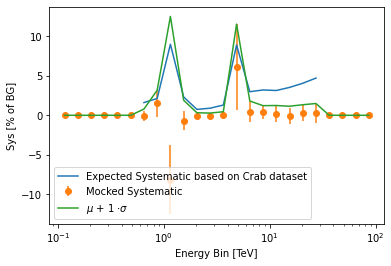

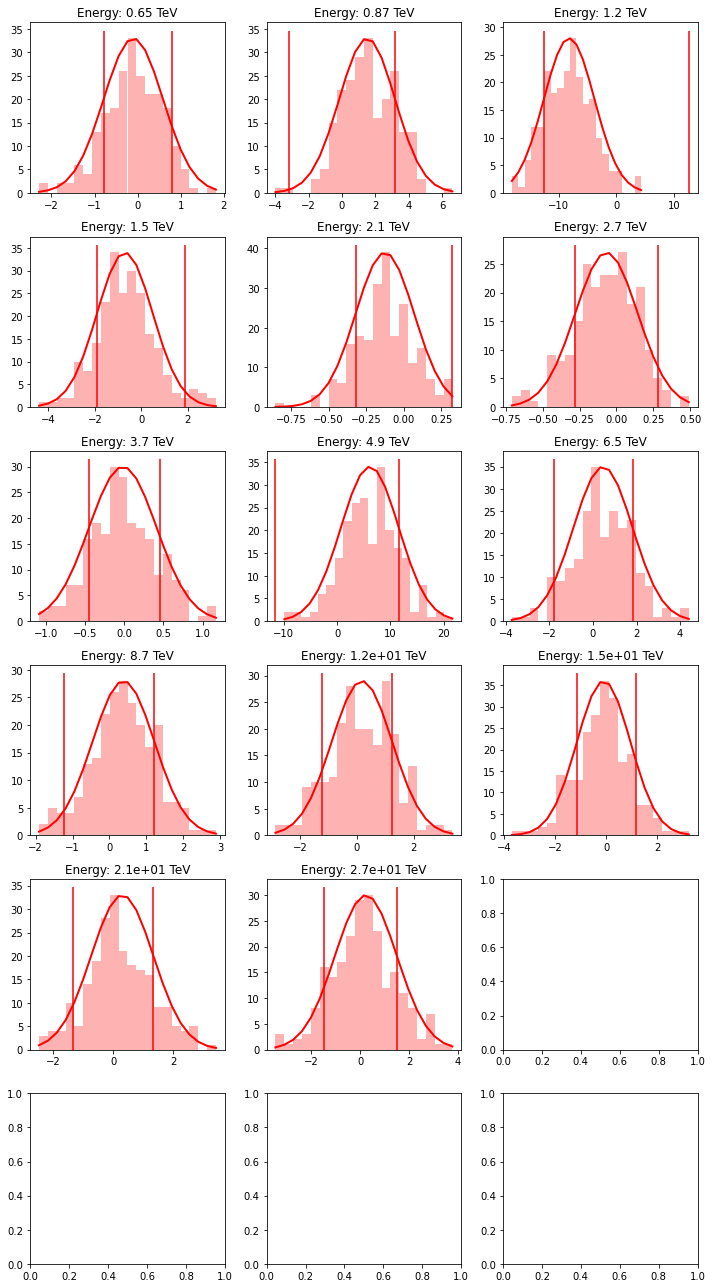

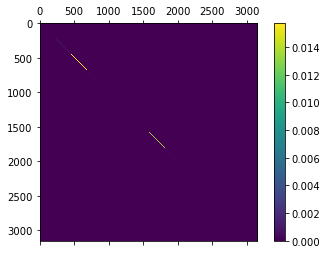

In [7]:
dataset_mock = create_dataset (mus, stds, 1, False)
plot_corr_matrix(dataset_mock)


In [8]:
def plot_mulitple_nui_distribution(datasets,  mus, stds):
    ilength = i_end - i_start
    ii = ilength //3 + 1
    fig, axs = plt.subplots(ii,3
                            , figsize =(20,7 * ii) )
    alpha = 1 / len(datasets)
    for i,e in enumerate(xaxis[i_start:i_end]):
        ax = axs.flatten()[i]
        mu, sigma_ = mus[i+i_start], stds[i+i_start]  # mean and standard deviation
        counts = []
        
        for j,dataset in enumerate(datasets):
            nui_values_co = dataset.N_parameters.value
            nui_values_co = np.array(nui_values_co) *100
            s = nui_values_co[i*amount_free_par : (i+1)* amount_free_par]
            range = (mu- 4 *  sigma_  , mu + 4*  sigma_  )
            
            nbins = range[1]- range[0]
            nbins = int(np.round(nbins)) * 10
            nbins = 50
            if j == 0:
                count, bins = np.histogram(s, bins = nbins, range = range)
                bin_center = (bins[1:] + bins[:-1] )/ 2        
                ax.plot(bin_center,count, alpha = alpha/1, color = 'cornflowerblue')
            else:
                count, bins = np.histogram(s, bins = bins)
                bin_center = (bins[1:] + bins[:-1] )/ 2        
                ax.plot(bin_center,count, alpha = alpha/1, color = 'cornflowerblue')
                
            counts.append(count)
            x = np.linspace(range[0],range[1], 100)
        ax.plot(x,  np.diff(bins)[0] *  sum(count)/ np.sqrt(2 * np.pi * sigma_**2)*
                                np.exp( - (x - mu)**2 / (2 * sigma_**2) ),
                          linewidth=2, color='midnightblue',alpha = 1,
               label = f"Mocked: \nGaus($\mu$ ={mu:.2}, $\sigma$ = {sigma_:.2})")
            
        counts = np.array(counts)        
        ax.set_title(f'Energy: {xaxis[i+i_start].value:.2} TeV')
        #bin_center = (bins[1:] + bins[:-1] )/ 2        
        ax.errorbar( x = bin_center,  y = counts.mean(axis= 0), yerr = counts.std(axis=0),
                   label = f'Mean of {len(counts)} Draws')
        ylim = [0,np.max(counts)]
        underepsi = (np.abs(mu)+ 0.5 * sigma_)
        epsi = (np.abs(mu)+ 1 * sigma_)
        overepsi = (np.abs(mu)+ 2 * sigma_)
        epsis = [underepsi,epsi, overepsi]
        labels= [f"Exp. {underepsi :.3}%  ($\mu + 0.5 \cdot \sigma$) ",
                f"Exp. {epsi :.3}%  ($\mu +  \sigma$) ",
                f"Exp. {overepsi :.3}%  ($\mu + 2 \cdot \sigma$) "]
        colors = ['darkorange', 'red', 'maroon']
        
        markertypes = ['o', 'x', 's']
        for i in np.arange(len(epsis)):
            ax.vlines(0 +epsis[i], ylim[0], ylim[1]  ,alpha = 1,color = colors[i],linewidth =2,
                 label = labels[i])
            ax.vlines(0 -epsis[i], ylim[0], ylim[1] ,alpha = 1,color = colors[i],linewidth =2,
                 label = '')
            ax.scatter(0+epsis[i], ylim[1], color = colors[i], marker= markertypes[i],s = 40)
            ax.scatter(0-epsis[i], ylim[1], color = colors[i], marker= markertypes[i],s = 40)
        
        #ax.set_ylim(-0.5, ylim[1])
        ax.legend()
        ax.set_xlabel("Mocked Systematic [% of BG]")
    plt.suptitle(f"Multiple Draws of Systematic based on Gaus (Crab) [% of BG]",
                     fontsize = 14)
    return fig


========== 0 ==========
[0.         0.         0.         0.         0.         0.
 0.00788192 0.03182808 0.12535756 0.01906312 0.00319179 0.00280429
 0.00450086 0.11561052 0.01815315 0.01218795 0.01240284 0.01148192
 0.0133735  0.01493884 0.         0.         0.         0.        ]

========== 1 ==========
[0.         0.         0.         0.         0.         0.
 0.00788192 0.03182808 0.12535756 0.01906312 0.00319179 0.00280429
 0.00450086 0.11561052 0.01815315 0.01218795 0.01240284 0.01148192
 0.0133735  0.01493884 0.         0.         0.         0.        ]

========== 2 ==========
[0.         0.         0.         0.         0.         0.
 0.00788192 0.03182808 0.12535756 0.01906312 0.00319179 0.00280429
 0.00450086 0.11561052 0.01815315 0.01218795 0.01240284 0.01148192
 0.0133735  0.01493884 0.         0.         0.         0.        ]

========== 3 ==========
[0.         0.         0.         0.         0.         0.
 0.00788192 0.03182808 0.12535756 0.01906312 0.00319179 0.

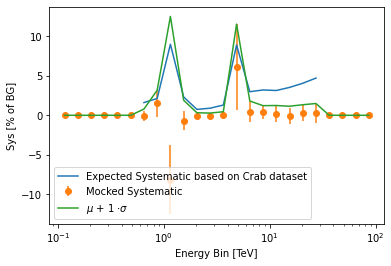

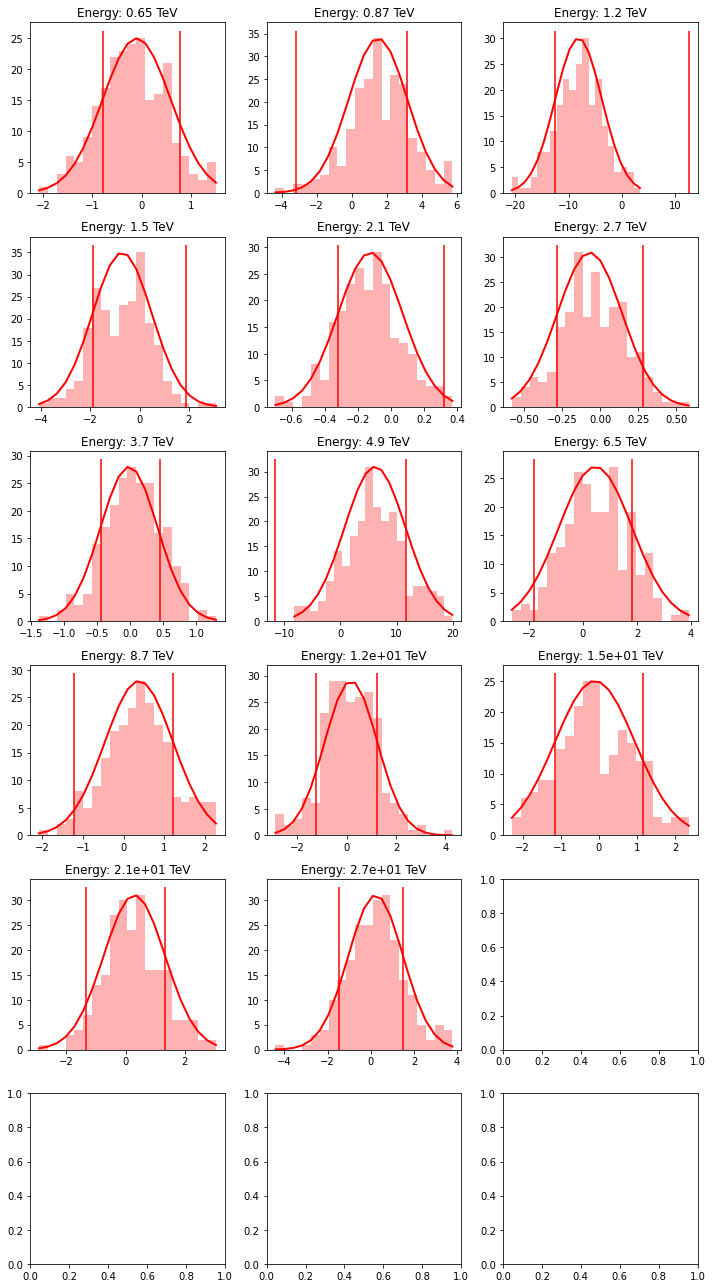

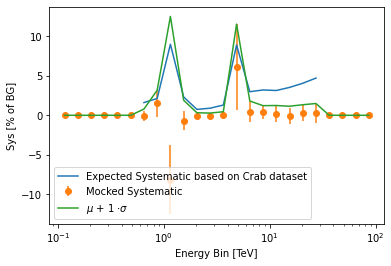

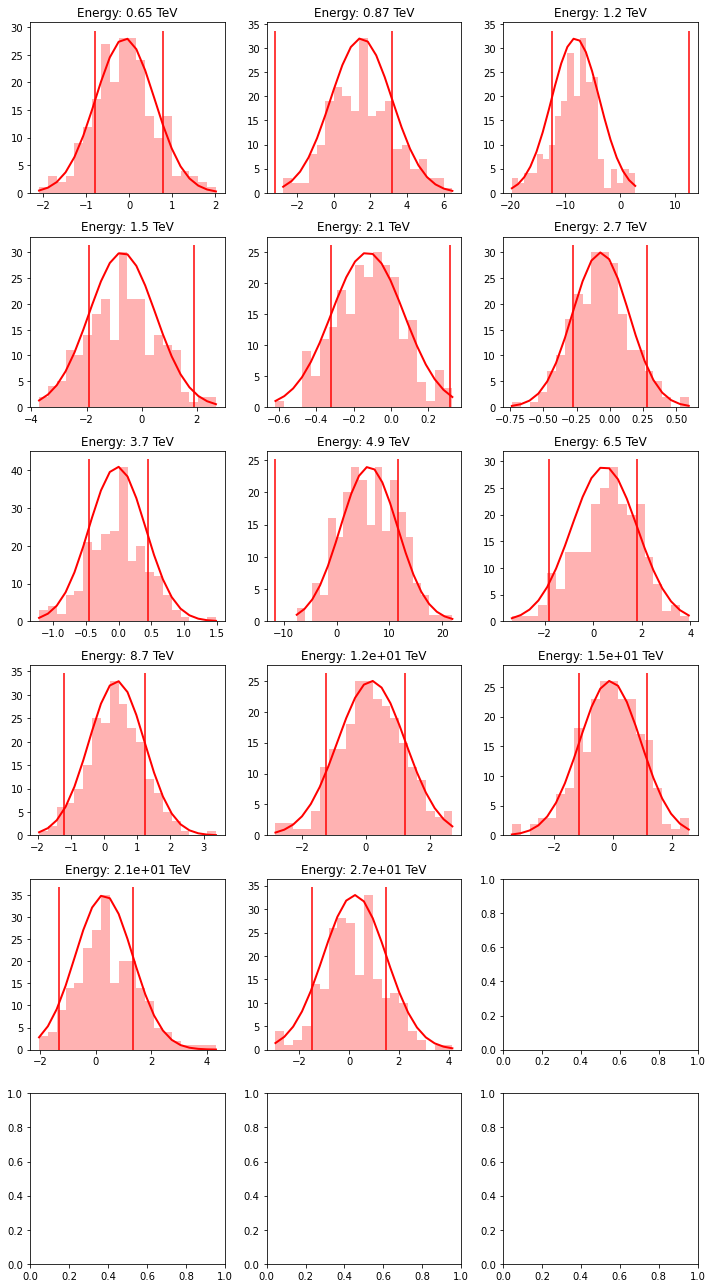

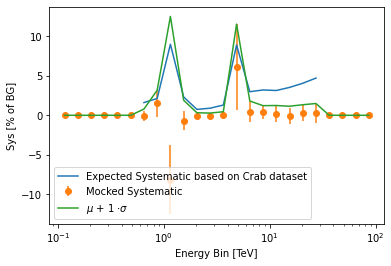

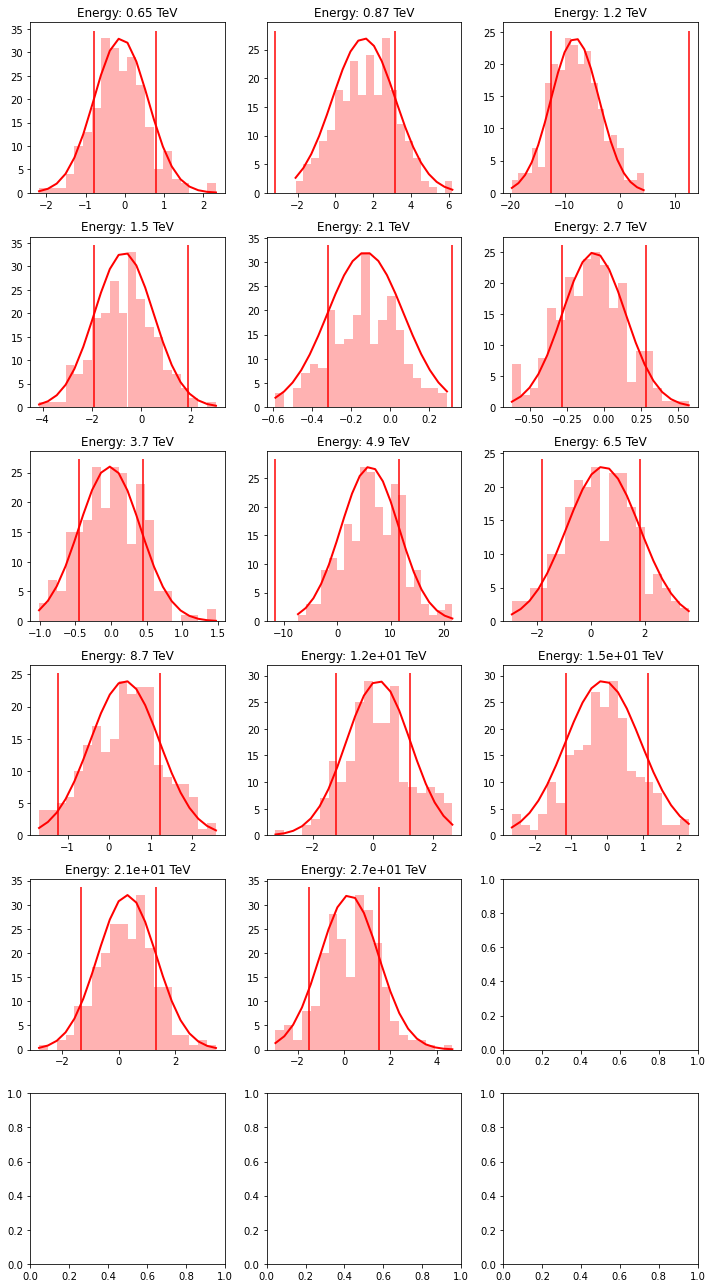

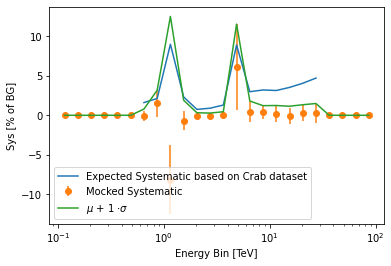

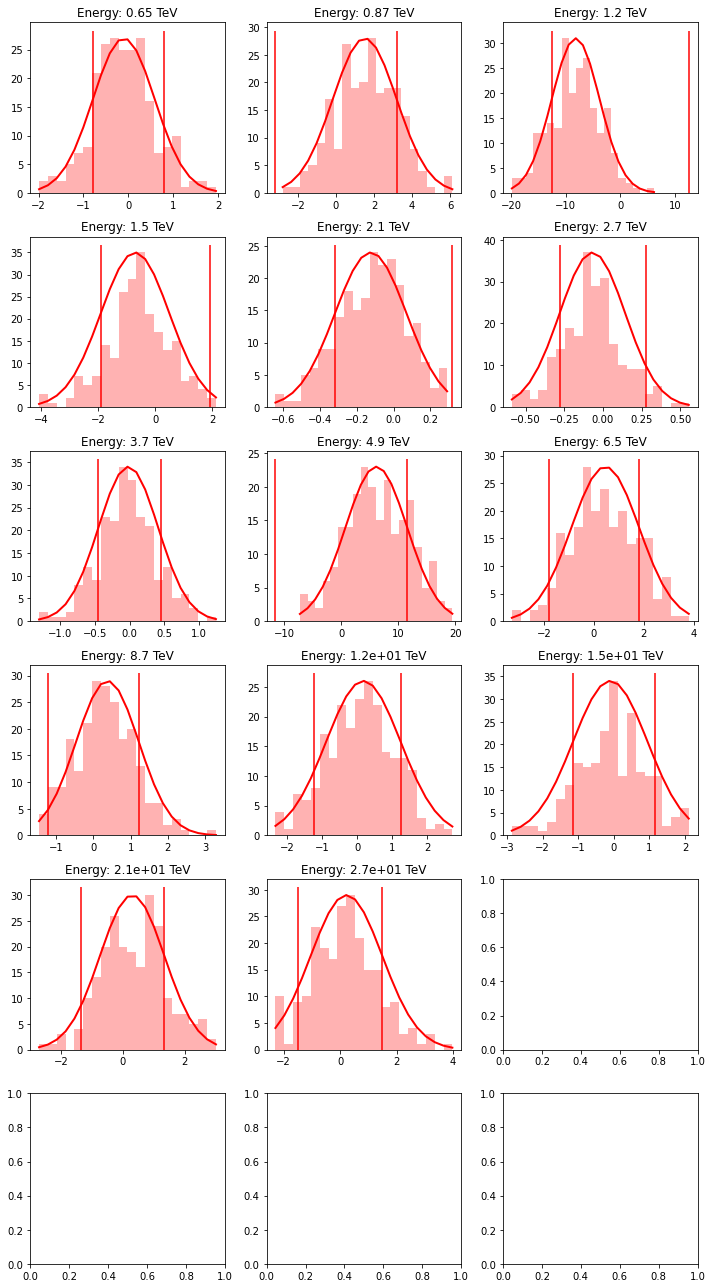

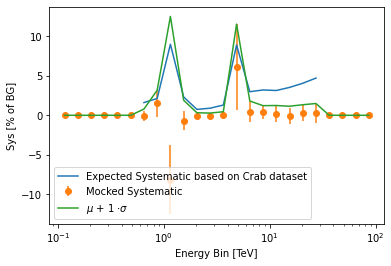

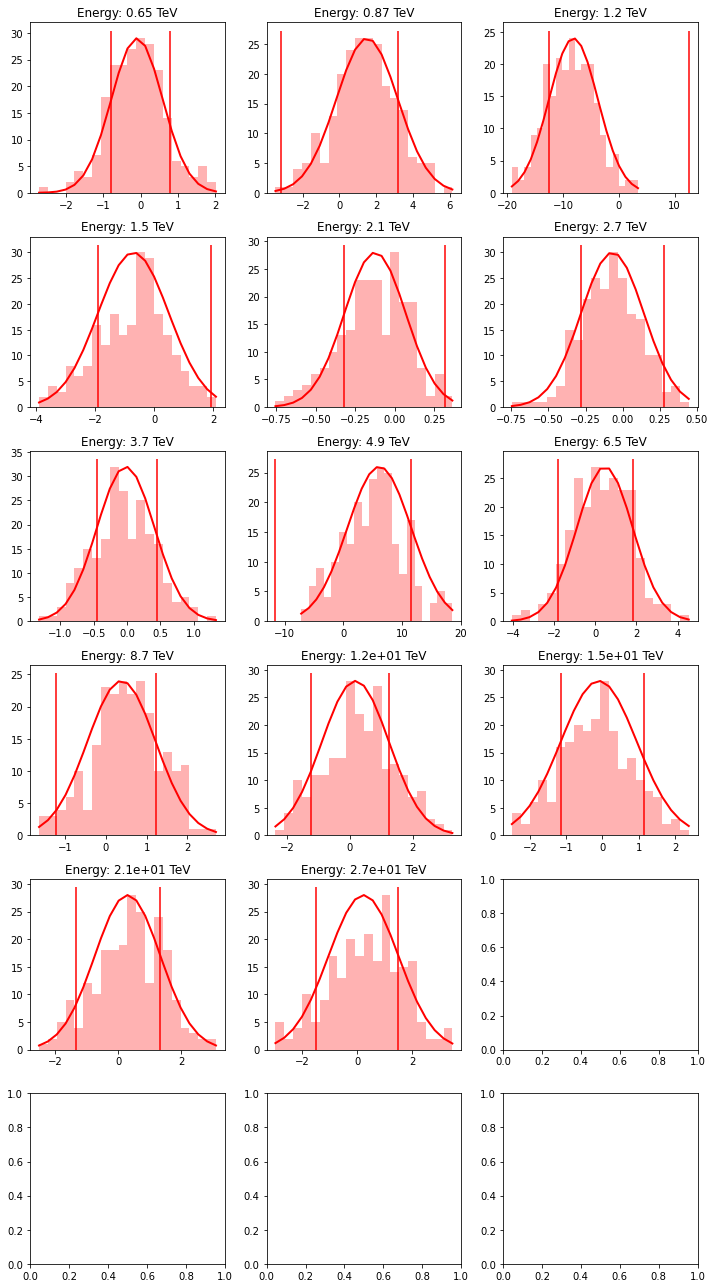

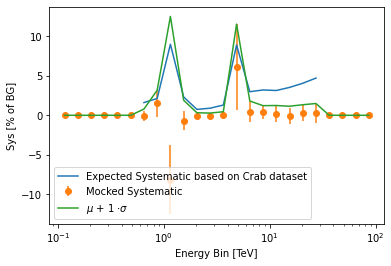

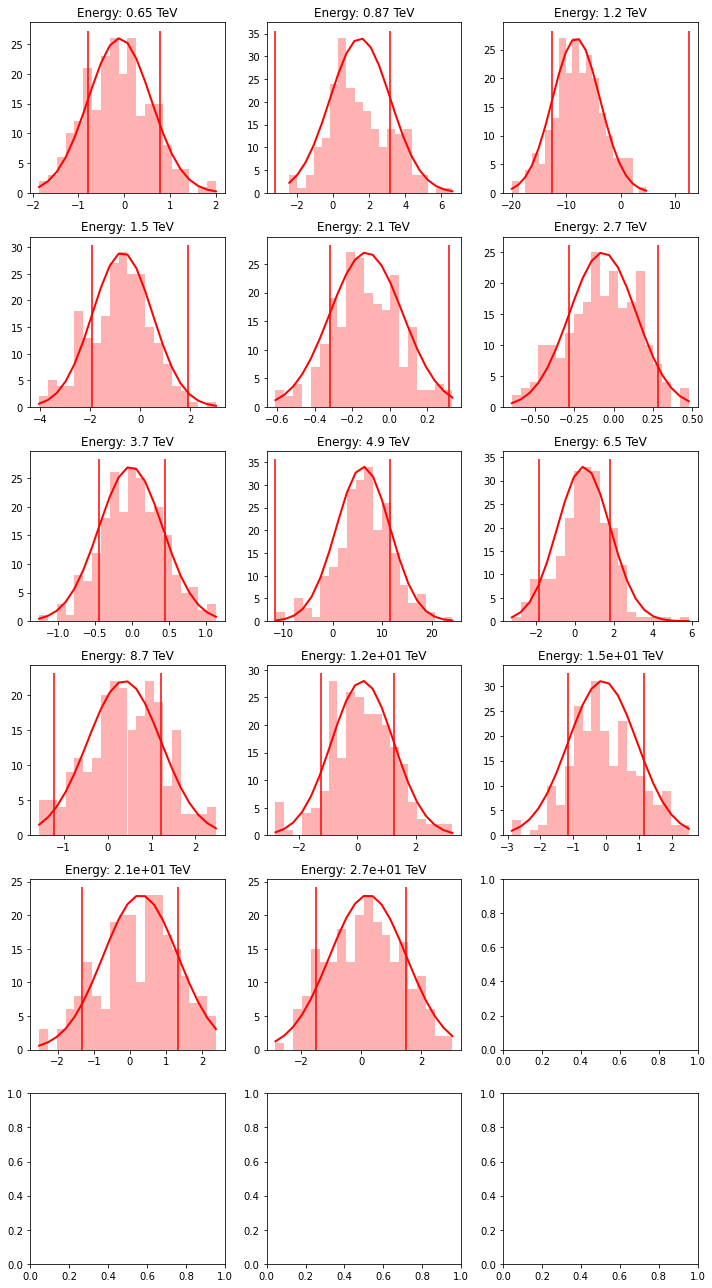

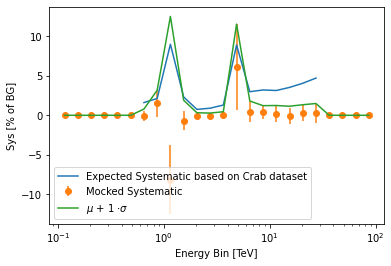

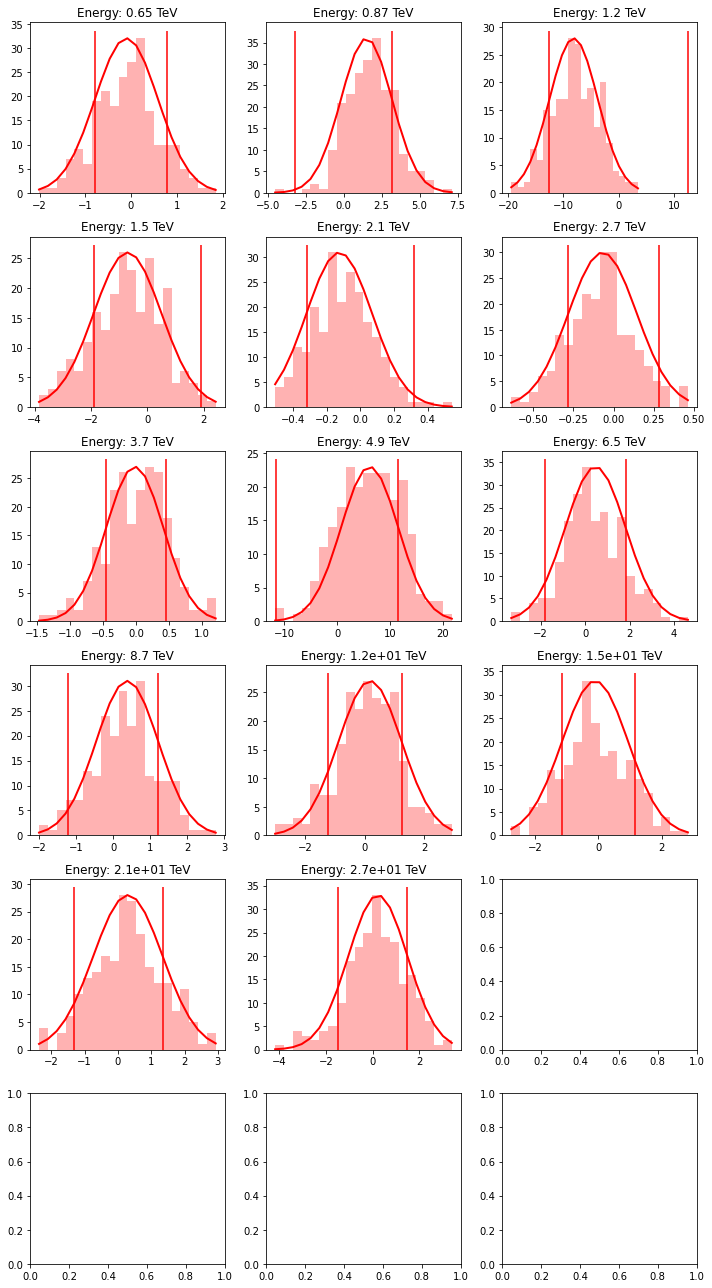

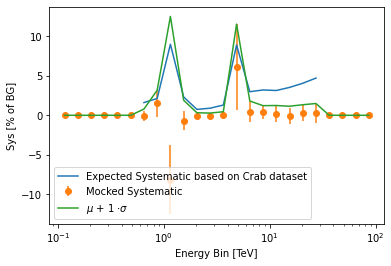

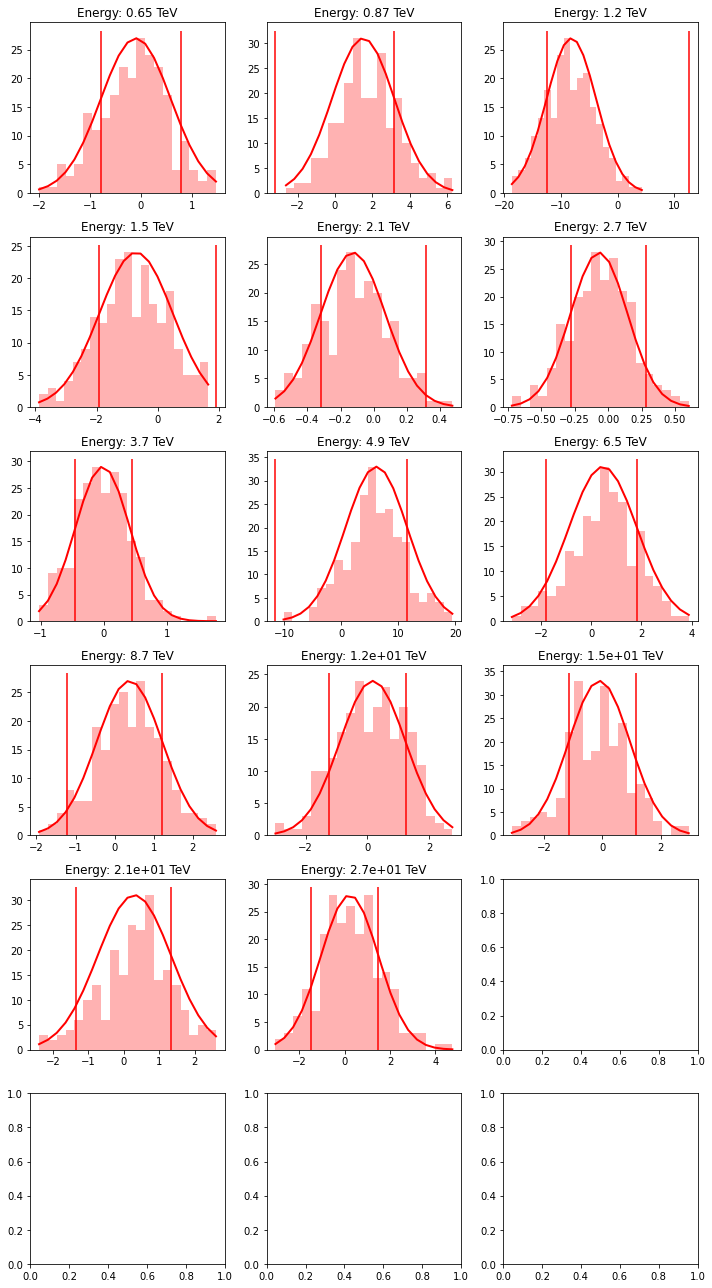

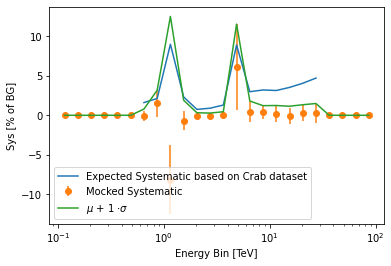

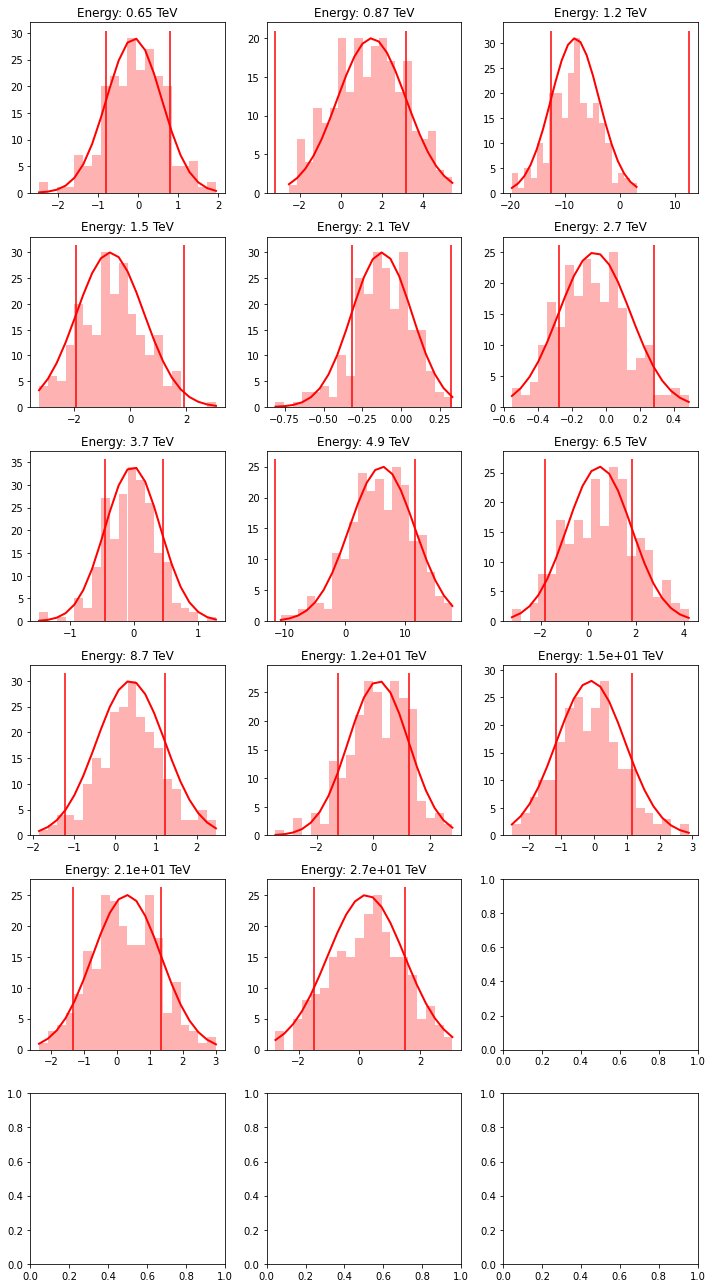

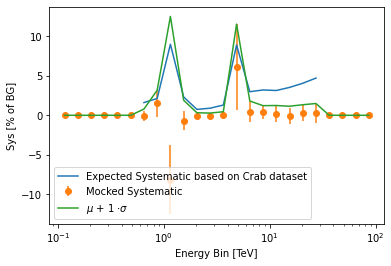

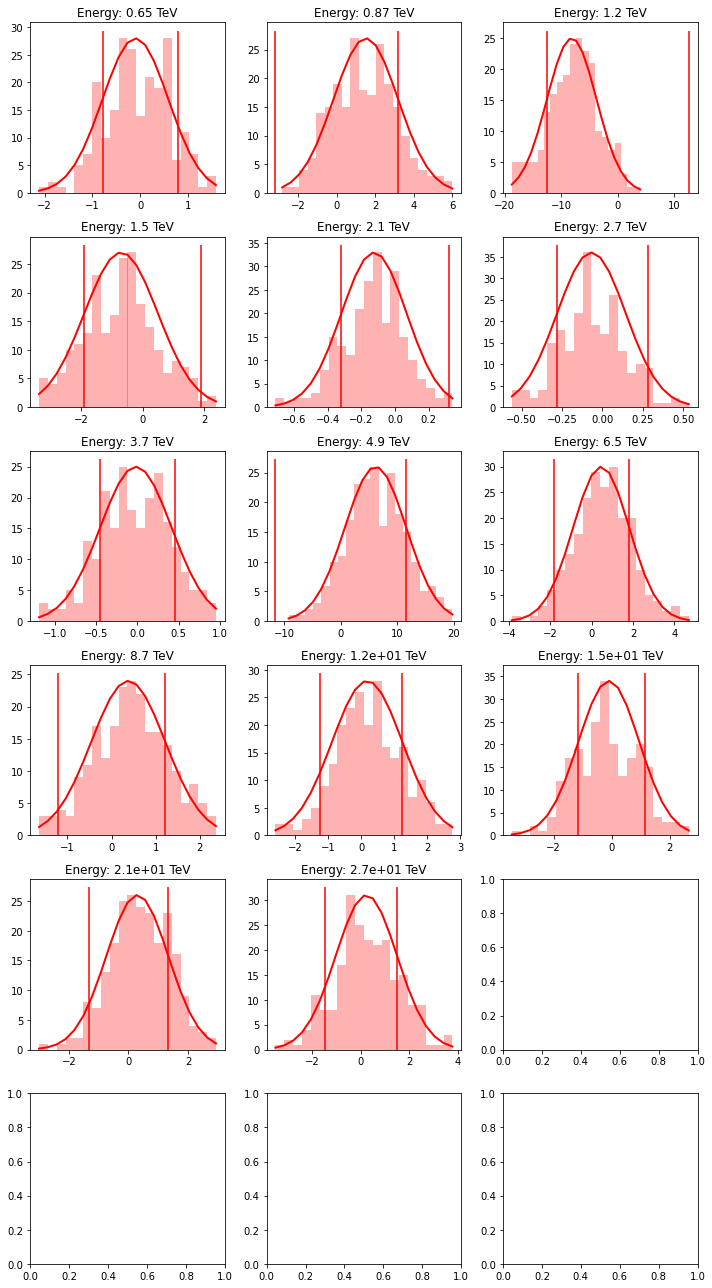

In [9]:
datasets_10 = []
for n in range(10):
    print()
    print( '=' * 10, n ,  '=' * 10)
    added = '_' +str(n)
    dataset_mock = create_dataset (mus, stds, 1, False)
    datasets_10.append(dataset_mock)
    


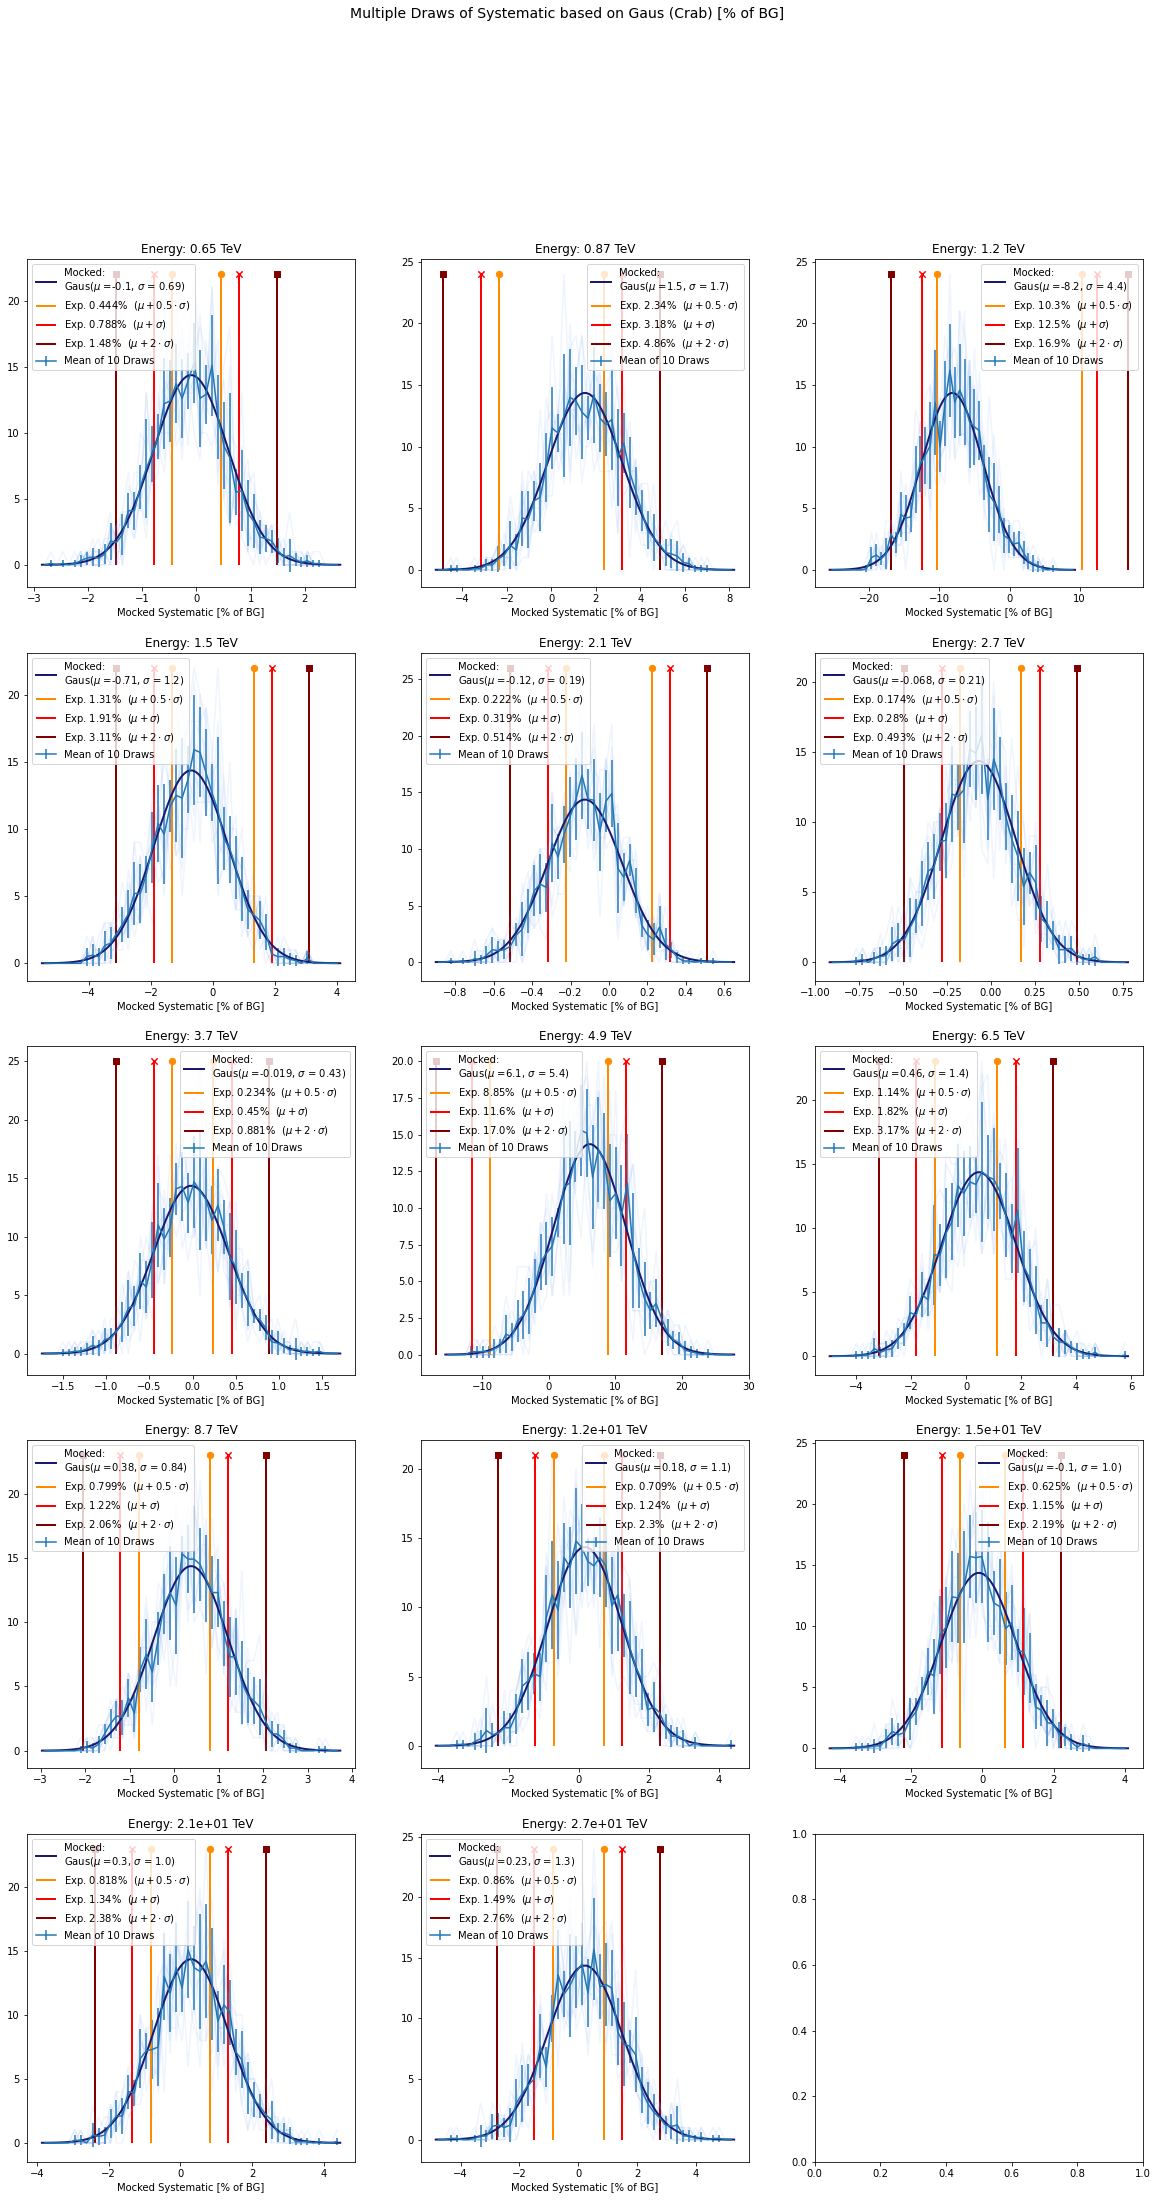

In [10]:
colors_case = ['darkorange', 'red', 'maroon']

fig = plot_mulitple_nui_distribution(datasets_10 ,  mus, stds)  
plt.savefig('plots/1_mocked_sys.png')


## Saving N = 100 Times

In [11]:

path_local_repo = '/home/saturn/caph/mppi045h/Nuisance_Asimov_Datasets'
'''
for n in range(100):
    print()
    print( '=' * 10, n ,  '=' * 10)
    added = '_' +str(n)
    dataset_mock = create_dataset (mus, stds, 1, False)
    print(f"save in: {path_local_repo}/nui_dataset{added}.fits" )
    print(f"and: {path_local_repo}/nui_bgmodel{added}.yml ")
    print()
    # save for now in this folder
    #dataset_mock.write(f'{path_local_repo}/nui_dataset{added}.fits', overwrite = True)
    #with open(f'{path_local_repo}/nui_par{added}.yml', 'w') as outfile:
    #        yaml.dump(dataset_mock.N_parameters.to_dict(), outfile, default_flow_style=False)

'''

'\nfor n in range(100):\n    print()\n    print( \'=\' * 10, n ,  \'=\' * 10)\n    added = \'_\' +str(n)\n    dataset_mock = create_dataset (mus, stds, 1, False)\n    print(f"save in: {path_local_repo}/nui_dataset{added}.fits" )\n    print(f"and: {path_local_repo}/nui_bgmodel{added}.yml ")\n    print()\n    # save for now in this folder\n    #dataset_mock.write(f\'{path_local_repo}/nui_dataset{added}.fits\', overwrite = True)\n    #with open(f\'{path_local_repo}/nui_par{added}.yml\', \'w\') as outfile:\n    #        yaml.dump(dataset_mock.N_parameters.to_dict(), outfile, default_flow_style=False)\n\n'

## Reading N= 100 

In [12]:
%%time
def read_mock_dataset(ad ):
    added = "_" + str(ad)
    dataset_N_sys = MapDatasetNuisance.read(f'{path_local_repo}/nui_dataset{added}.fits')
    with open(f'{path_local_repo}/nui_par{added}.yml', "r") as ymlfile:
        nui_par = yaml.load(ymlfile, Loader=yaml.FullLoader)
    dataset_N_sys.N_parameters = Parameters.from_dict(nui_par )
    bkg_model = FoVBackgroundModel(dataset_name=dataset_N_sys.name)
    models = Models([])
    models.append(bkg_model)
    dataset_N_sys.models =models
    return dataset_N_sys

datasets_100 = []
for i in range(100):
    datasets_100.append(read_mock_dataset(i))


CPU times: user 6min 8s, sys: 13.8 s, total: 6min 22s
Wall time: 6min 29s


## Create Signal-to-Sys-plots

In [13]:
amplitude =1.0e-12* u.Unit('cm-2 s-1 TeV-1')

models = Models.read("1a-Source_models.yaml")
model_types = models.names
model_asimov = models[model_types[0]]
model_asimov.parameters['amplitude'].value = amplitude.value
print(model_asimov)

SkyModel

  Name                      : pointsource_center
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                   :      2.400   +/-    0.00             
    amplitude               :   1.00e-12   +/- 0.0e+00 1 / (cm2 s TeV)
    reference    (frozen)   :      1.000       TeV         
    lon_0                   :     83.600   +/-    0.00 deg         
    lat_0                   :     22.000   +/-    0.00 deg         




In [14]:
def compute_uncertainty_to_noise(dataset , spatial_model_type , bg_norm = 1 ):
    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.parameters['tilt'].frozen =False

    dataset.models = Models([bkg_model])
    
    map_mask = get_mask(spatial_model_type)
    bg = (dataset.background*bg_norm*map_mask).data.sum(axis=2).sum(axis=1)
    sys = (np.abs(dataset.npred_background() - dataset.background)*map_mask).sum(axis=2).sum(axis=1)
    stat = np.sqrt(bg)
    return stat , sys, bg


In [15]:
def compute_signal_to_noise(dataset , amplitude  ,spatial_model_type , bg_norm = 1, index =2.4 *u.Unit('')):
    if spatial_model_type != 'CompleteFoV':
        model_asimov_testing = models[spatial_model_type]
        model_asimov_testing.parameters['index'].value = index.value
        model_asimov_testing.parameters['amplitude'].value = amplitude.value
        
        models_testing = Models(model_asimov_testing) 
    else:
        models_testing = Models() 

    bkg_model = FoVBackgroundModel(dataset_name=dataset.name)
    bkg_model.parameters['tilt'].frozen =False

    models_testing.append(bkg_model)
    dataset.models = models_testing

    signal = dataset.npred_signal().data.sum(axis=2).sum(axis=1)

    return  signal


In [16]:
amplitudes_point = ['1e-14',
 '2.1544346900318866e-14',
 '4.6415888336127726e-14',
 '1e-13',
 '2.1544346900318868e-13',
 '4.641588833612772e-13',
 '1e-12',
 '2.154434690031878e-12',
 '4.6415888336127725e-12',
 '1e-11',
 '2.1544346900318777e-11',
 '4.641588833612773e-11',
 '1e-10',
 '2.1544346900318779e-10',
 '4.6415888336127727e-10',
 '1e-09']

In [17]:


def get_mask(spatial_model_type):
    geom = datasets_10[0].geoms['geom']
    center_coord = geom.center_skydir
    if spatial_model_type == "pointsource_center":
        skyregion = CircleSkyRegion(center=center_coord, radius = 0.3 *u.deg)
    if spatial_model_type ==  "CompleteFoV":
        skyregion = CircleSkyRegion(center=center_coord, radius = 20.3 *u.deg)
    if spatial_model_type == "gaussiansource_center":
        skyregion = CircleSkyRegion(center=center_coord, radius = 0.5 *u.deg)
    if spatial_model_type == "gaussiansource_offcenter":
        center_coord = SkyCoord(83.6*u.deg + 1*u.deg, 
                                22.0*u.deg + 1*u.deg,
                                frame = "icrs")
        skyregion = CircleSkyRegion(center=center_coord, radius = 0.5 *u.deg)
    if spatial_model_type == "largegaussiansource_center":
        skyregion = CircleSkyRegion(center=center_coord, radius = 2.0 *u.deg)
        
        

    map_mask= Map.from_geom(geom, 
                                data=geom.region_mask([skyregion], inside=True).data)

    return map_mask


pointsource_center  a larger : 1e-12
gaussiansource_center  a larger : 1e-12
largegaussiansource_center  a larger : 1e-10


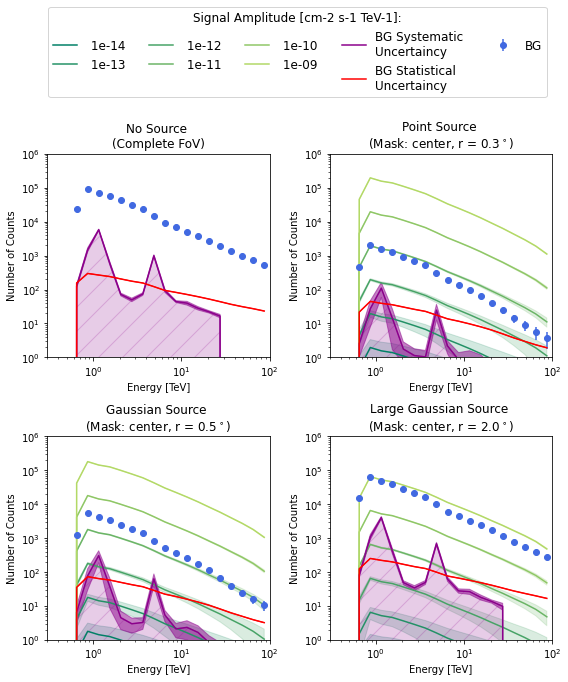

In [24]:
fig, ax = plt.subplots(2,2, figsize = (8,8))
ebins = datasets_10[0].geoms['geom'].axes[0].center.value

titles =dict()
titles['CompleteFoV'] = 'No Source \n(Complete FoV)'
titles['pointsource_center'] = 'Point Source \n(Mask: center, r = $0.3^\circ$)'
titles['gaussiansource_center'] = 'Gaussian Source \n(Mask: center, r = $0.5^\circ$)'
titles['largegaussiansource_center'] = 'Large Gaussian Source \n(Mask: center, r = $2.0^\circ$)'

labels =dict()
labels['bg'] = 'BG'
labels['sys'] = 'BG Systematic \nUncertaincy'
labels['stat'] = 'BG Statistical \nUncertaincy'
labels_empty =dict()
labels_empty['bg'] = ''
labels_empty['stat'] = ''
labels_empty['sys'] = ''
from matplotlib import cm
a_is = [0,3,9,15]
a_is = [0,3,6,9,12,15]

start = 0.0
stop = 0.7
number_of_lines= len(a_is)
cm_subsection = np.linspace(start, stop, number_of_lines) 
colors = [ cm.summer(x) for x in cm_subsection ]
a_threshold = dict()
for i,bg_norm in enumerate([1.0]):#, 1,10.5]):
    for j, spatial_model_type in enumerate(["CompleteFoV", "pointsource_center",
                                           "gaussiansource_center", "largegaussiansource_center"]):
        a = ax.flatten()[j]
        a_larger = []
        for k, a_i in enumerate(a_is):
            signal  = compute_signal_to_noise(
                                        dataset = datasets_10[0],
                                          bg_norm =bg_norm, 
                                        spatial_model_type =spatial_model_type,
                                        amplitude = float(amplitudes_point[a_i]) * u.Unit('cm-2 s-1 TeV-1'))
            stats , syss, bgs = [], [], []
            for i in range(len(datasets_10)):
                stat , sys, bg = compute_uncertainty_to_noise(
                                        dataset = datasets_10[i],
                                          bg_norm =bg_norm, 
                                        spatial_model_type =spatial_model_type)
                stats.append(stat); syss.append(sys); bgs.append(bg)
            
            labels_dict = labels_empty
            if spatial_model_type  !=  "CompleteFoV":
                label = ''
                if a_i%3 == 0 and j ==1 :
                    label = " " + str(amplitudes_point[a_i] )
                    labels_dict = labels
                    
                a.plot(ebins, signal, label = label, #+' 1/cm2sTeV'
                       color = colors[k])
                a.fill_between(ebins,signal - np.sqrt(signal), signal+ np.sqrt(signal),
                              label = '',  color = colors[k] , alpha = 0.2)
                if np.sum(signal) > np.sum(sys):
                    a_larger.append(amplitudes_point[a_i])
        try:
            print(spatial_model_type, " a larger :",a_larger[0] )
            a_threshold[spatial_model_type] = a_larger[0] 
        except:
            print()
                #a.errorbar(ebins, signal, yerr = np.sqrt(signal),fmt= 'x',
                #           label = "Signal " + str(amplitudes_point[a_i]), color = colors[k])
        
        a.errorbar(x= ebins, y = np.mean(bgs, axis = 0), yerr= np.mean(stats, axis = 0),
                   fmt='o', label = labels_dict['bg'], color = "royalblue")
        #ax[0].plot(ebins, sys, label = "sys" )
        syss_mean, syss_std = np.mean(syss, axis = 0), np.std(syss, axis = 0)
        stats_mean, stats_std = np.mean(stats, axis = 0), np.std(stats, axis = 0)
        color_stat = 'red'
        color_sys = 'darkmagenta'
        a.fill_between(ebins,[1e-3]*len(syss_mean), syss_mean
                       , label = '' , 
                       color = color_sys, alpha = 0.2,
                           hatch = '/')
        
        a.plot(ebins, syss_mean, color =color_sys, label = labels_dict['sys'])
        a.fill_between(ebins, syss_mean - syss_std, syss_mean + syss_std , 
                   label = '', color = color_sys , alpha = 0.5)
        a.plot(ebins,stats_mean, 
                   label = labels_dict['stat'], color = color_stat )
        a.fill_between(ebins, stats_mean - stats_std, stats_mean + stats_std , 
                   label = '', color = color_stat , alpha = 0.5)
        a.set_yscale('log');    a.set_ylabel('Number of Counts');
        a.set_ylim(1e0, 1e6); a.set_title(titles[spatial_model_type])
    #plt.plot(ratios[1]*100, label = "sys" +str(bg_norm))
    
for a in ax.flatten():
    #a.legend(ncol = 2)
    a.set_xscale('log'); a.set_xlabel("Energy [TeV]")
    a.set_xlim(3e-1, 1e2)

fig.legend( title = 'Signal Amplitude [cm-2 s-1 TeV-1]:',loc= 'center left', 
           bbox_to_anchor=(0.08, 1.1), ncol = 5,
          fontsize = 12,title_fontsize = 12 ,bbox_transform=fig.transFigure)
fig.subplots_adjust(right=0.7)
plt.tight_layout()

import json
# has to be done with all the amplitudes!
#with open('1-amplitudes_where_sys_smaller.json', 'w') as fp:
#    json.dump(a_threshold, fp, indent=4)

plt.savefig('plots/1_signal_uncertainty_to_bg_ratio.png',  bbox_inches='tight')
plt.savefig('plots/1_signal_uncertainty_to_bg_ratio.pdf',  bbox_inches='tight')

plt.show()
